In [78]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


In [2]:
print(torch.cuda.is_available())#cuda = 11.8
print(torch.cuda.device_count())

True
1


In [80]:
!cudatoolkit --version

'cudatoolkit' is not recognized as an internal or external command,
operable program or batch file.


In [81]:
 torch.__version__

'1.12.1'

In [82]:
print(torch.version.cuda)

None


In [3]:
from fastai.vision.all import *
from fastai.data.core import DataLoaders
import os
import pathlib
import torch
import torchvision
import PIL
from PIL import Image
import torchvision.transforms as transforms
import re
import numpy as np
import random
from fastai.vision.learner import create_body
from torchvision.models import resnet34

In [4]:
def label_func(fname):
    #ラベル情報を取得_データを種類ごとに分けるため(正規表現)
    return re.match(r'^(.*)\d\d\d\d.png$', (fname.name)).groups()[0]#.*＃

In [5]:
files = get_image_files('./gray_set')
files[0]

Path('gray_set/aed0000.png')

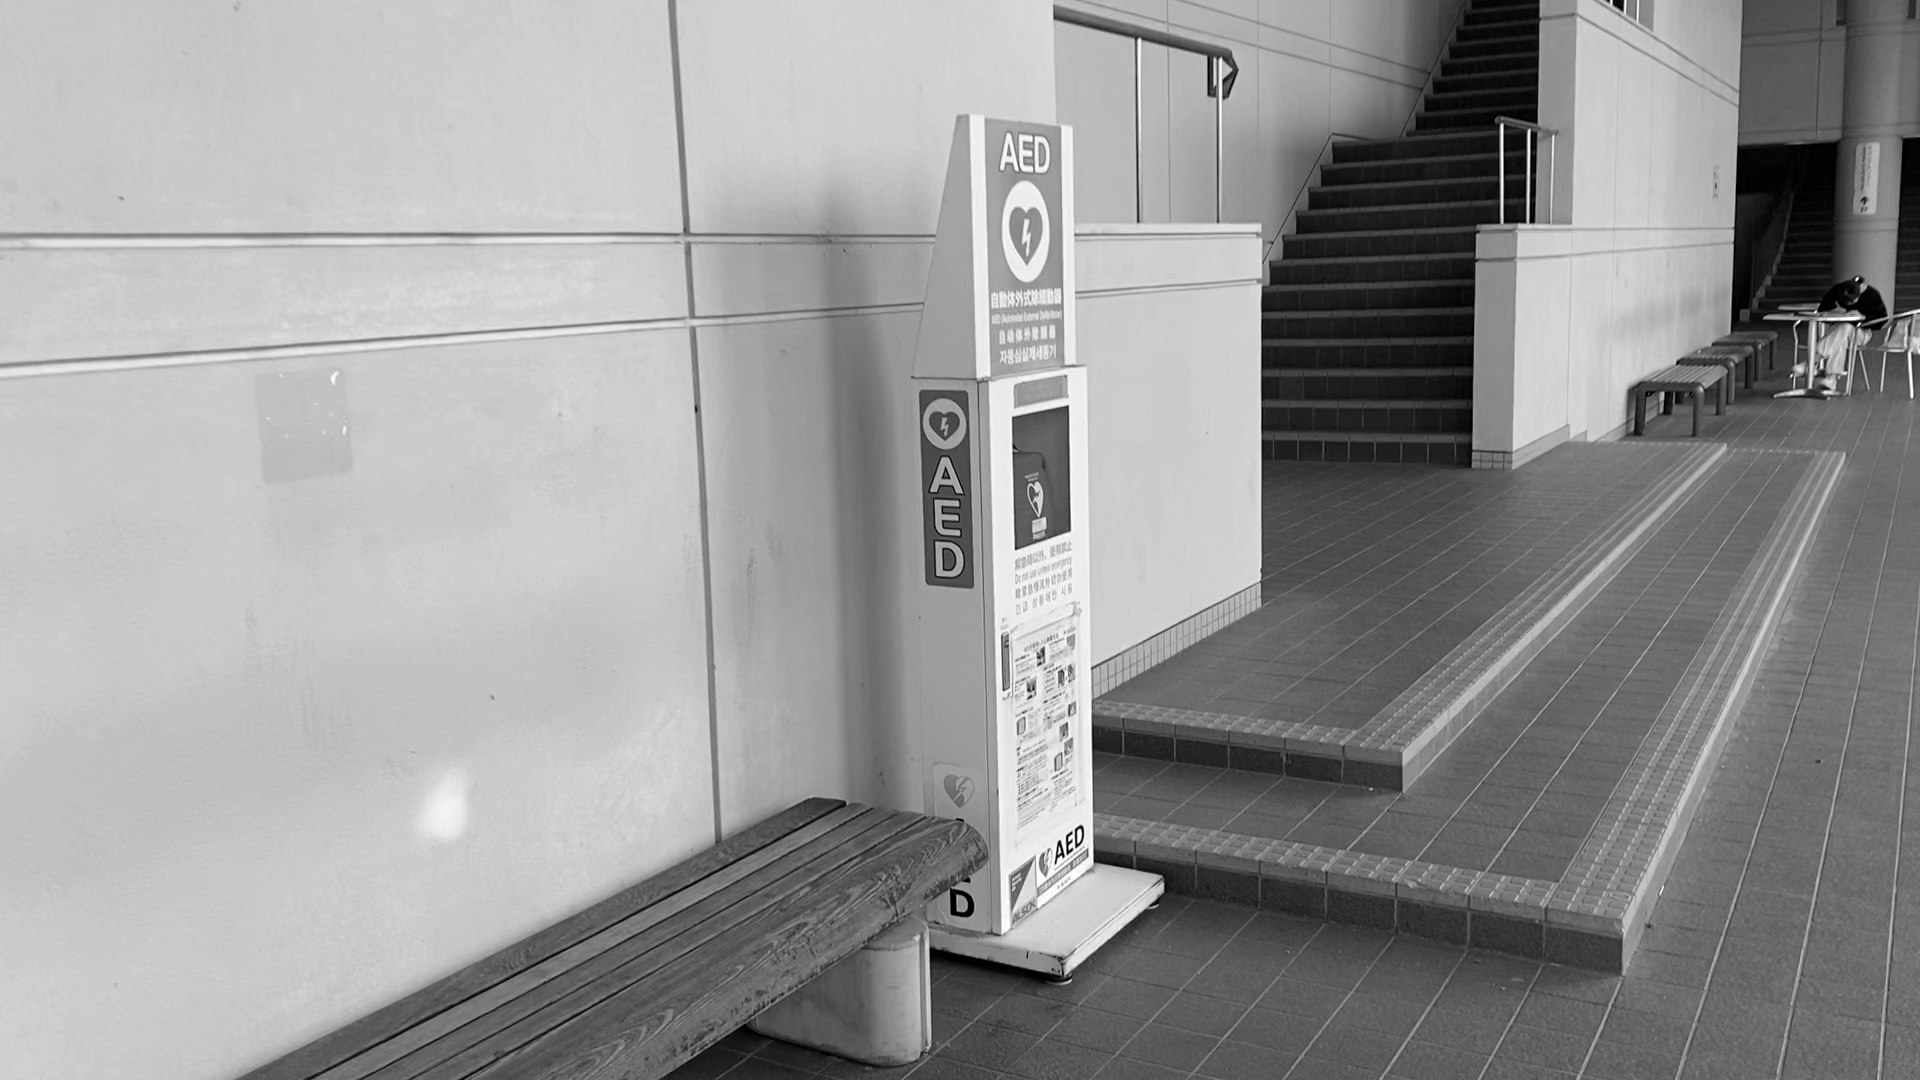

In [6]:
img = PIL.Image.open(files[0])
img

In [7]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

open_image(files[0]).shape

torch.Size([3, 224, 224])

In [8]:
label_func(files[0])

'aed'

In [9]:
labels = list(set(files.map(label_func)))
len(labels)

8

In [10]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}
print(lbl2files)

{'crecore': [Path('gray_set/crecore0000.png'), Path('gray_set/crecore0003.png'), Path('gray_set/crecore0006.png'), Path('gray_set/crecore0009.png'), Path('gray_set/crecore0012.png'), Path('gray_set/crecore0015.png'), Path('gray_set/crecore0018.png'), Path('gray_set/crecore0021.png'), Path('gray_set/crecore0024.png'), Path('gray_set/crecore0027.png'), Path('gray_set/crecore0030.png'), Path('gray_set/crecore0033.png'), Path('gray_set/crecore0036.png'), Path('gray_set/crecore0039.png'), Path('gray_set/crecore0042.png'), Path('gray_set/crecore0045.png'), Path('gray_set/crecore0048.png'), Path('gray_set/crecore0051.png'), Path('gray_set/crecore0054.png'), Path('gray_set/crecore0057.png'), Path('gray_set/crecore0060.png'), Path('gray_set/crecore0063.png'), Path('gray_set/crecore0066.png'), Path('gray_set/crecore0069.png'), Path('gray_set/crecore0072.png'), Path('gray_set/crecore0075.png'), Path('gray_set/crecore0078.png'), Path('gray_set/crecore0081.png'), Path('gray_set/crecore0084.png'), P

In [11]:
#データセットの定義
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [12]:
#データセット作成
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [13]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [14]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)
b = dls.one_batch()
dls = dls.cuda()#GPU用

#ここまでデータセットの作成
#低レベルのデータセット定義　拡張性がない

In [15]:
print(torch.cuda)
print(torch.cuda.device_count())

<module 'torch.cuda' from 'c:\\Users\\hiram\\anaconda3\\envs\\py39-cuda\\lib\\site-packages\\torch\\cuda\\__init__.py'>
1


In [16]:
#画像を正規化したり、データ拡張を適用したりする場合、fastai にすでにあるものをすべて書き直
#上のSiameseDatasetをアップグレード
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

#SimeseDatasetクラスの    
#the __len__ disappeared, we won’t need it
#__getitem___ became encodes
#we return TensorImage for our images

In [17]:
#SimeseTransformを使ってデータセットの作成
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [18]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [19]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

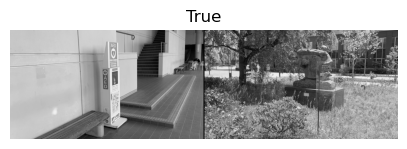

In [20]:
#確かめ用
img = PILImage.create(files[0])
img1 = PILImage.create(files[1000])
s = SiameseImage(img, img1, True)#Trueに設定しているだけ
s.show();

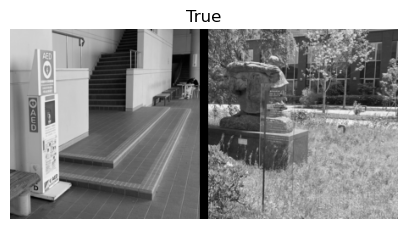

In [21]:
#resize
#PILではなくfastaiに対応するようにして変換します
tst = Resize(224)(s)#ResizeはFastaiのメソッド
tst = ToTensor()(tst)#tensor変換
tst.show();

In [22]:
#クラスを改良　変わっているが意味はよくわからない
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))#Loss関数によって，sameをintにしたり，boolにしたりしろ！！！
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same


In [23]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [24]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

<Axes: title={'center': '0'}>

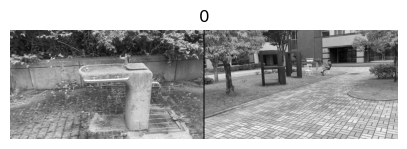

In [25]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0)

In [26]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [27]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

In [28]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [29]:
b = dls.one_batch()
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

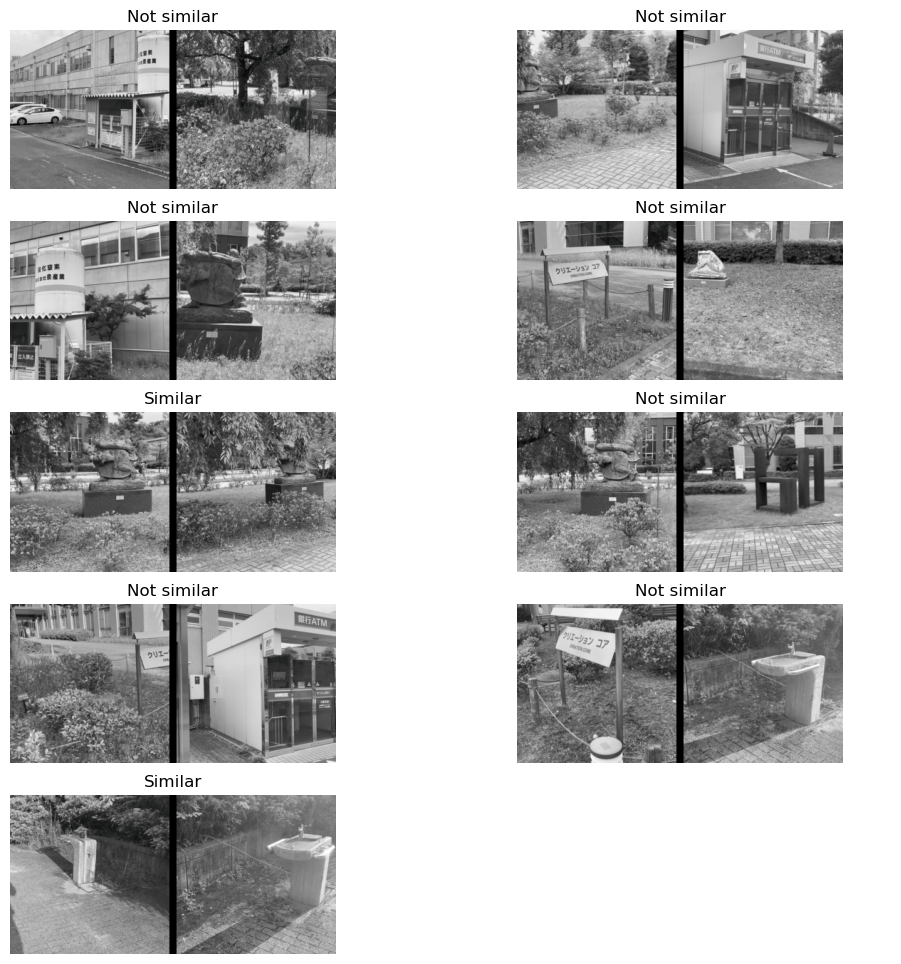

In [30]:
dls.show_batch()

In [31]:
#カスタム データ ブロックの書き込みが必要な時もある？？？？？

In [32]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [33]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

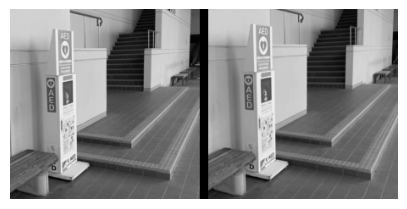

In [34]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [35]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [36]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [37]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

In [38]:
splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]
splbl2files

[{'crecore': [Path('gray_set/crecore1549.png'),
   Path('gray_set/crecore1435.png'),
   Path('gray_set/crecore0042.png'),
   Path('gray_set/crecore0378.png'),
   Path('gray_set/crecore0360.png'),
   Path('gray_set/crecore1105.png'),
   Path('gray_set/crecore0000.png'),
   Path('gray_set/crecore1120.png'),
   Path('gray_set/crecore1165.png'),
   Path('gray_set/crecore1321.png'),
   Path('gray_set/crecore1618.png'),
   Path('gray_set/crecore1363.png'),
   Path('gray_set/crecore1009.png'),
   Path('gray_set/crecore1591.png'),
   Path('gray_set/crecore0399.png'),
   Path('gray_set/crecore0003.png'),
   Path('gray_set/crecore0330.png'),
   Path('gray_set/crecore1069.png'),
   Path('gray_set/crecore1501.png'),
   Path('gray_set/crecore1300.png'),
   Path('gray_set/crecore1423.png'),
   Path('gray_set/crecore1477.png'),
   Path('gray_set/crecore0009.png'),
   Path('gray_set/crecore0024.png'),
   Path('gray_set/crecore1096.png'),
   Path('gray_set/crecore1270.png'),
   Path('gray_set/crecore00

In [39]:
def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)

In [40]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(splbl2files[split][cls]),same

In [41]:
def get_tuples(files): return [[f, *draw_other(f)] for f in files]

In [42]:
def get_x(t): return t[:2]
def get_y(t): return t[2]
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [43]:
dls = siamese.dataloaders(files)
b = dls.one_batch()
explode_types(b)


{tuple: [{__main__.ImageTuple: [fastai.torch_core.TensorImage,
    fastai.torch_core.TensorImage]},
  fastai.torch_core.TensorCategory]}

In [44]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

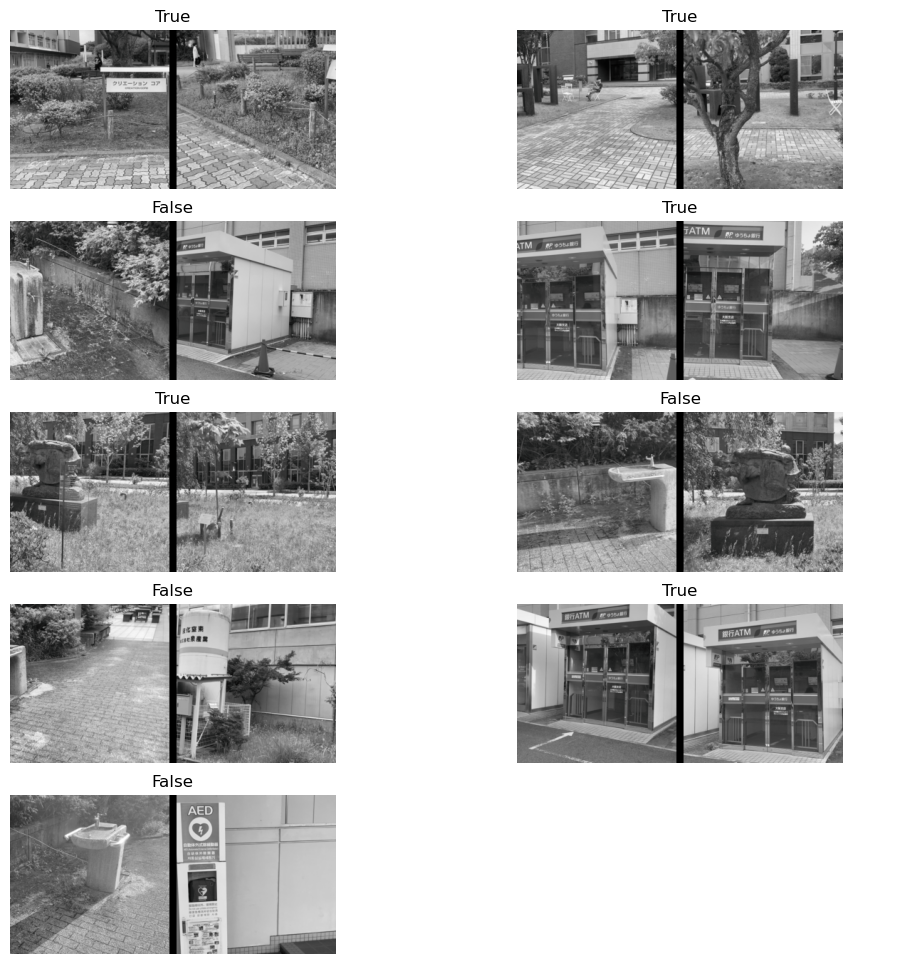

In [45]:
dls.show_batch()

In [45]:
#モデルの学習へ

In [46]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [47]:
model_meta[resnet34]
#このモデルでは．最後の2層分が取り除かれている
#通常の場合問題ない

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [48]:
encoder = create_body(resnet34(), pretrained=True, cut=-2)#上のー２を用いて

In [49]:
#エンコーダーの最後の層の様子
#512の特徴数になっていることが分かる
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [50]:
head = create_head(512*2, 2, ps=0.5)#入力チャンネル，出力チャンネル数(ap+mp)，ｐｓ
model = SiameseModel(encoder, head)

In [51]:
head
#2枚の画像それぞれではなく，統合して出力するときの内容
#2048はap+mpの入力次元数
#出力層が2層分定義されている 2048->512->2

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [52]:
#モデルをエンコーダー部分とヘッド部分に分ける　ヘッドは学習しパラメータが変わっていく
#ヘッド部分は，転移学習に大切
#学習済みモデルを使ってさらに新しいデータを学習させるときに効率よく学習させるために重要な役割
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [53]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())
#targ変数は整数である必要ありー＞ラベルを文字じゃなくて整数で表す必要アリ？
#Then we use the traditional CrossEntropyLossFlat loss function from fastai (the same as nn.CrossEntropyLoss, but flattened). The only thing is, if using the data built by the mid-level API, we have a tensor of bools for our targets, so we need to convert it to integers otherwise PyTorch will throw an error.

In [54]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [55]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [56]:
#2つとも書いて損はない
learn.freeze()#再学習の効率を上げるとか

SuggestedLRs(valley=0.0004786300996784121)

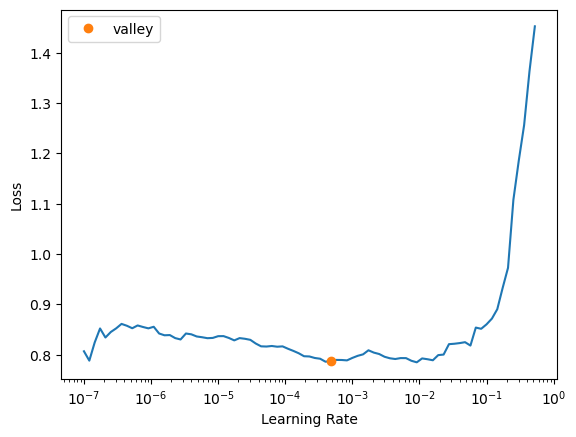

In [62]:
learn.lr_find()#最適な学習率を見つける

In [57]:
#クラス数が重要ですか？?
learn.fit_one_cycle(40, 3e-3)

In [58]:
learn.unfreeze()

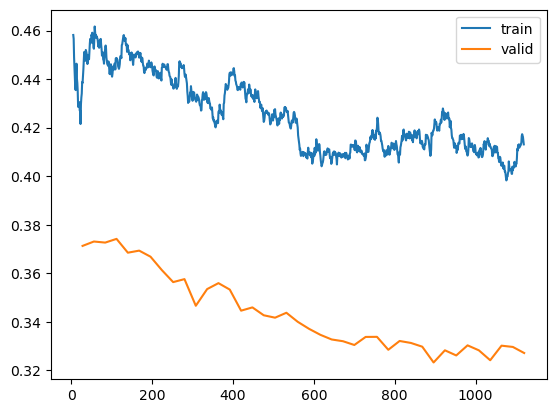

In [59]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))
learn.recorder.plot_loss()
import pickle


In [67]:
with open('models/grayset_40_40epoch.pickle', mode='wb') as fp:
    pickle.dump(learn, fp)

In [79]:
#結果画像表示用
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=10, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)
        print(y[1][0])

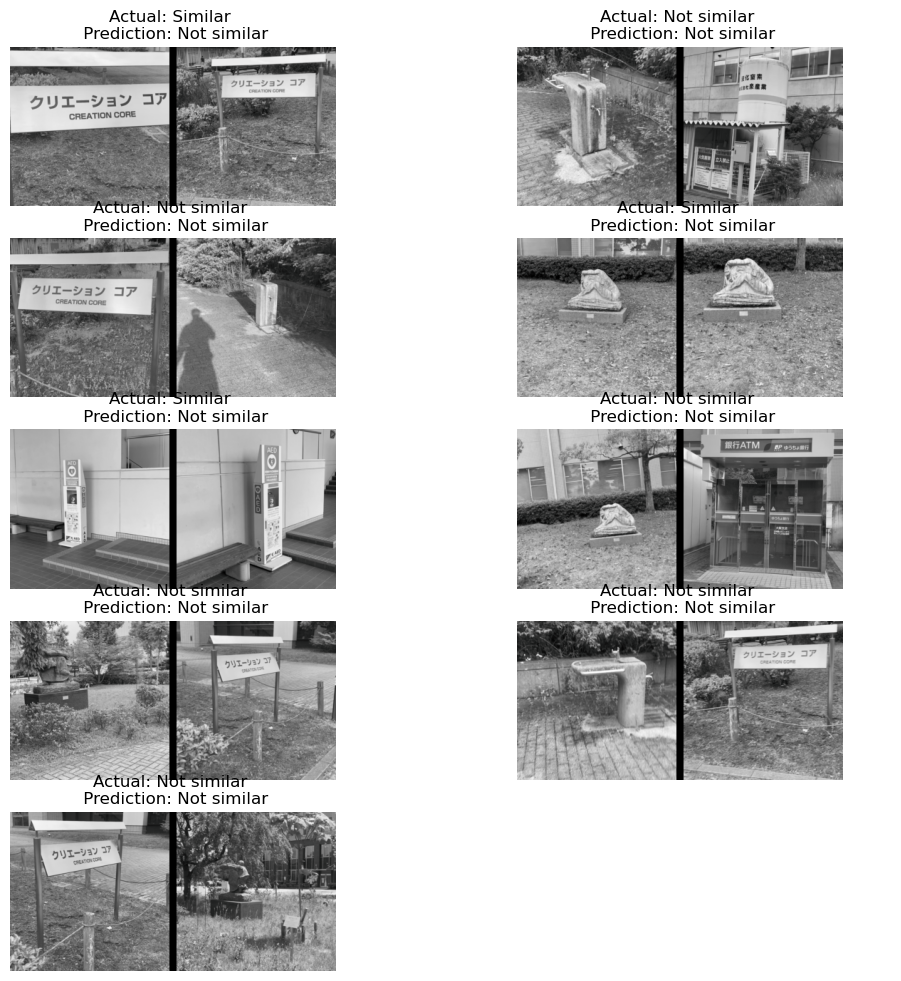

In [68]:
#学習結果表示
learn.show_results()

In [64]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    #クロスエントロピーだから類似度に意味がない
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

In [1]:
@patch
def siampredict2(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    print(res)
imgtrain = PILImage.create(files[0])
imgtest = PILImage.create(test_files[7])
siamtest = SiameseImage(imgtrain, imgtest)
#siamtest.show();
res = learn.siampredict2(siamtest)

NameError: name 'patch' is not defined

In [59]:
test_files = get_image_files('./test_image')

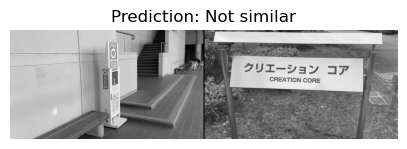

In [73]:
imgtrain = PILImage.create(files[0])
imgtest = PILImage.create(test_files[7])
siamtest = SiameseImage(imgtrain, imgtest)
#siamtest.show();
res = learn.siampredict(siamtest)

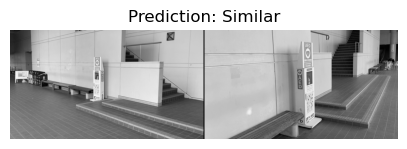

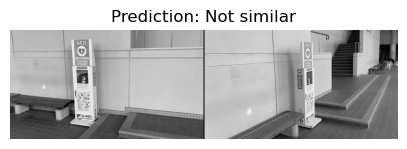

In [91]:
res = learn.siampredict(siamtest)

In [56]:
import pickle
with open('./models/grayset_40_40epoch.pickle', mode='rb') as fp:
     clf = pickle.load(fp)#clfは学習済みのleanerと同義

In [57]:
clf

In [62]:
clf.predict(test_files[0])

(tensor(0), tensor(0), tensor([0.9700, 0.0300]))

c:\Users\hiram\anaconda3\envs\py39-cuda\lib\site-packages\fastai\torch_core.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  if ax is None: _,ax = plt.subplots(figsize=figsize)


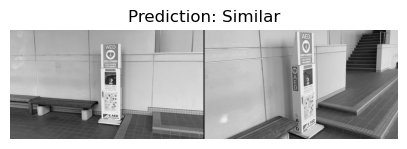

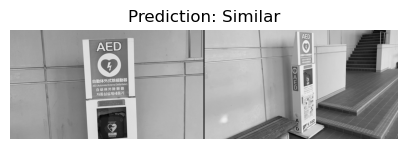

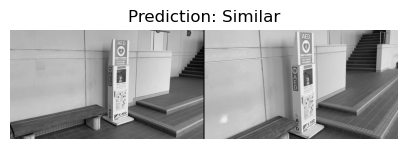

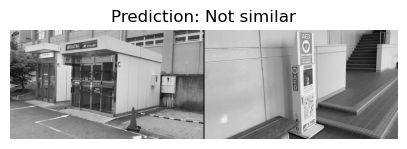

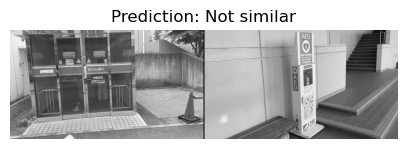

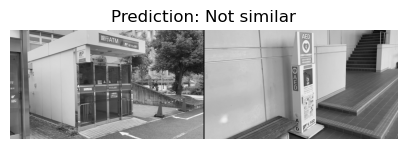

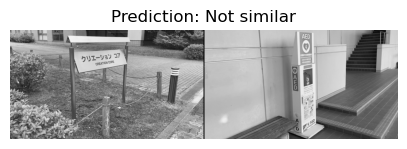

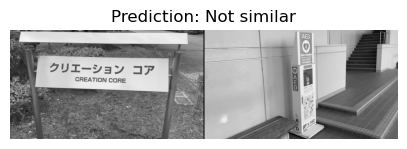

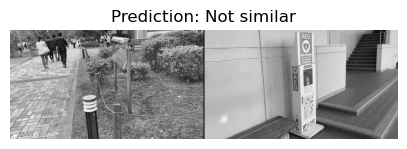

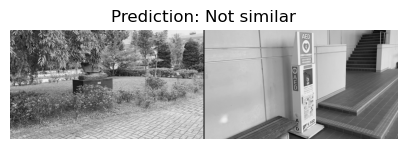

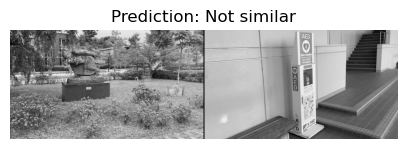

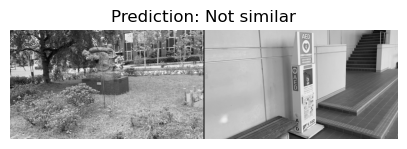

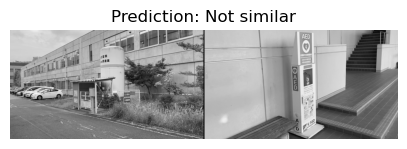

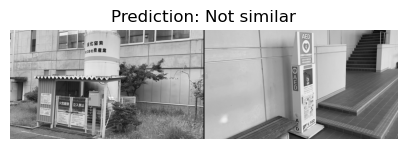

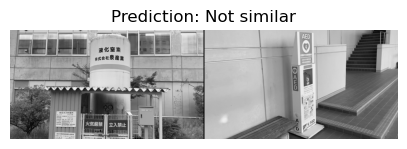

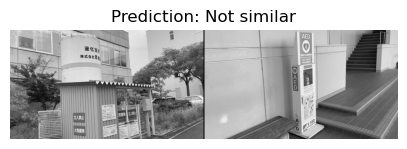

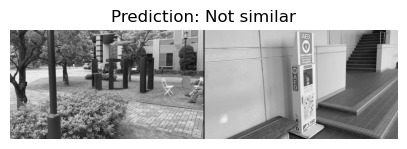

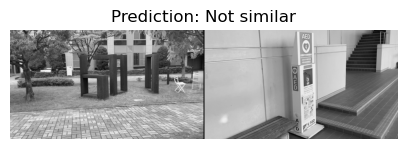

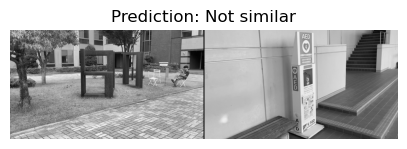

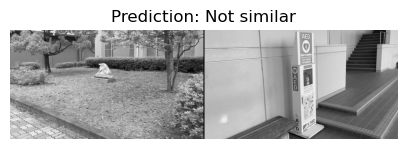

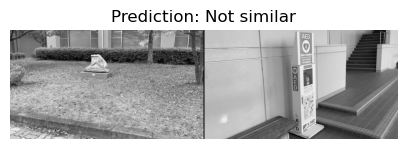

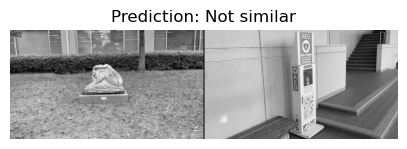

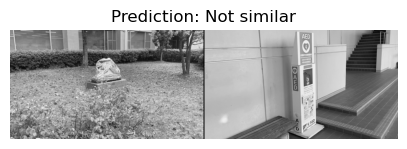

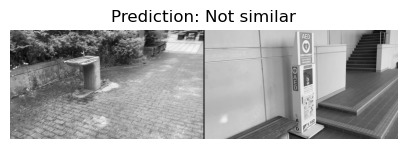

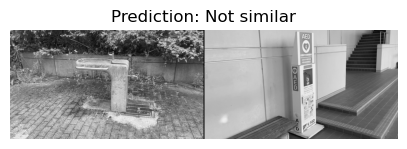

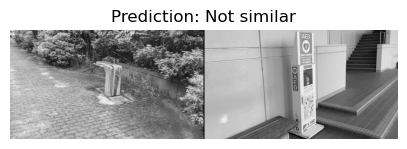

In [89]:
for i,f1 in enumerate(test_files):
    imgtest = PILImage.create(test_files[i])
    imgtrain = PILImage.create(files[10])
    siamtest = SiameseImage(imgtest, imgtrain)
    #siamtest.show();
    res = clf.siampredict(siamtest)

In [ ]:
for j,f2 in enumerate(train_files[::500]):
        try:
            imgtrain = PILImage.create(files[j])
            siamtest = SiameseImage(imgtrain, imgtest)
        except IndexError:
            break


TensorImage([[[ 53,  50,  46,  ..., 160, 146, 153],
              [ 69,  66,  63,  ..., 172, 148, 151],
              [ 62,  77,  63,  ..., 185, 173, 166],
              ...,
              [153, 169, 164,  ..., 153, 146, 142],
              [170, 184, 176,  ..., 151, 153, 163],
              [182, 198, 197,  ..., 144, 156, 179]],

             [[ 53,  50,  47,  ..., 160, 146, 153],
              [ 69,  66,  63,  ..., 172, 148, 151],
              [ 62,  77,  64,  ..., 185, 173, 166],
              ...,
              [153, 169, 164,  ..., 153, 146, 142],
              [170, 184, 176,  ..., 151, 153, 163],
              [182, 198, 197,  ..., 144, 156, 179]],

             [[ 53,  50,  47,  ..., 160, 146, 153],
              [ 69,  66,  63,  ..., 172, 148, 151],
              [ 62,  77,  64,  ..., 185, 173, 166],
              ...,
              [153, 169, 164,  ..., 153, 146, 142],
              [170, 184, 176,  ..., 151, 153, 163],
              [182, 198, 197,  ..., 144, 156, 179]]])
T

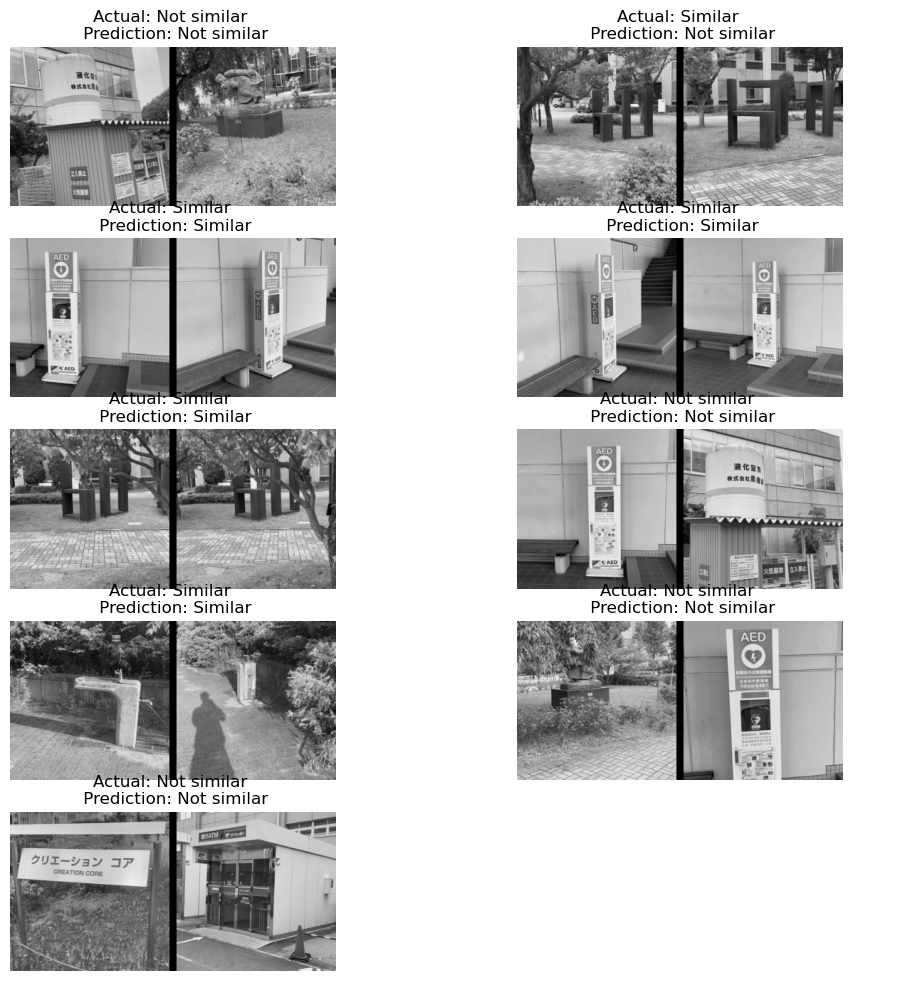

In [80]:
clf.show_results()

In [ ]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    for i,ctx in enumerate(): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)
        print(y[1][0])
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

